# Домашнее задание 2. CycleGAN

## Загрузка данных


>Решением домашки является архив с использованными тетрадками/модулями. Необходимо объяснять каждый пункт решения. В нем необходимо описать какие эксперименты вы производили для полученного результата, а так же обосновать почему вы решили использовать те или иные вариации и хаки для ганов - например, дополнительные лоссы для стабилизации и т.п.

In [1]:
!git clone https://github.com/Lornatang/CycleGAN-PyTorch

%mkdir CycleGAN-PyTorch
%cd CycleGAN-PyTorch

Cloning into 'CycleGAN-PyTorch'...


f:\GitHub\HSE\gen_models\hw2\CycleGAN-PyTorch


�������� ��� 䠩� CycleGAN-PyTorch 㦥 �������.


In [2]:
!pip install -r requirements.txt
!pip install munch

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2+cu118 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1)
ERROR: No matching distribution found for torchvision==0.15.2+cu118


In [6]:
import requests, zipfile
from io import BytesIO

download_link = "https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip"

%cd CycleGAN-PyTorch\data

r = requests.get(download_link, stream=True)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()

%cd CycleGAN-PyTorch

F:\GitHub\HSE\gen_models\hw2\CycleGAN-PyTorch\data
[WinError 2] Не удается найти указанный файл: 'CycleGAN-PyTorch'
F:\GitHub\HSE\gen_models\hw2\CycleGAN-PyTorch\data


In [11]:
%cd F:\GitHub\HSE\gen_models\hw2
%cd CycleGAN-PyTorch

F:\GitHub\HSE\gen_models\hw2
F:\GitHub\HSE\gen_models\hw2\CycleGAN-PyTorch


In [14]:
import argparse
import itertools
import os
import random

import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
from tqdm.auto import tqdm

%run dataset.py
%run imgproc.py
%run model.py
%run utils.py

from munch import Munch


In [15]:
args = Munch()
args.dataroot = "./data"
args.dataset="horse2zebra"
args.testA="testA"
args.testB="testB"
args.trainA="trainA"
args.trainB="trainB"
args.batch_size=1
args.cuda=True
args.image_size=256
args.manualSeed=1

if args.manualSeed is None:
    args.manualSeed = random.randint(1, 10000)
random.seed(args.manualSeed)
torch.manual_seed(args.manualSeed)

# Creating a Dataset and a Dataloader

In [16]:
cudnn.benchmark = True

if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Dataset
dataset = ImageDataset(src_images_dir=os.path.join(args.dataroot, args.dataset, args.trainA),
                       dst_images_dir=os.path.join(args.dataroot, args.dataset, args.trainB),
                       resized_image_size=int(args.image_size * 1.12),
                       unpaired=True,
                       )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


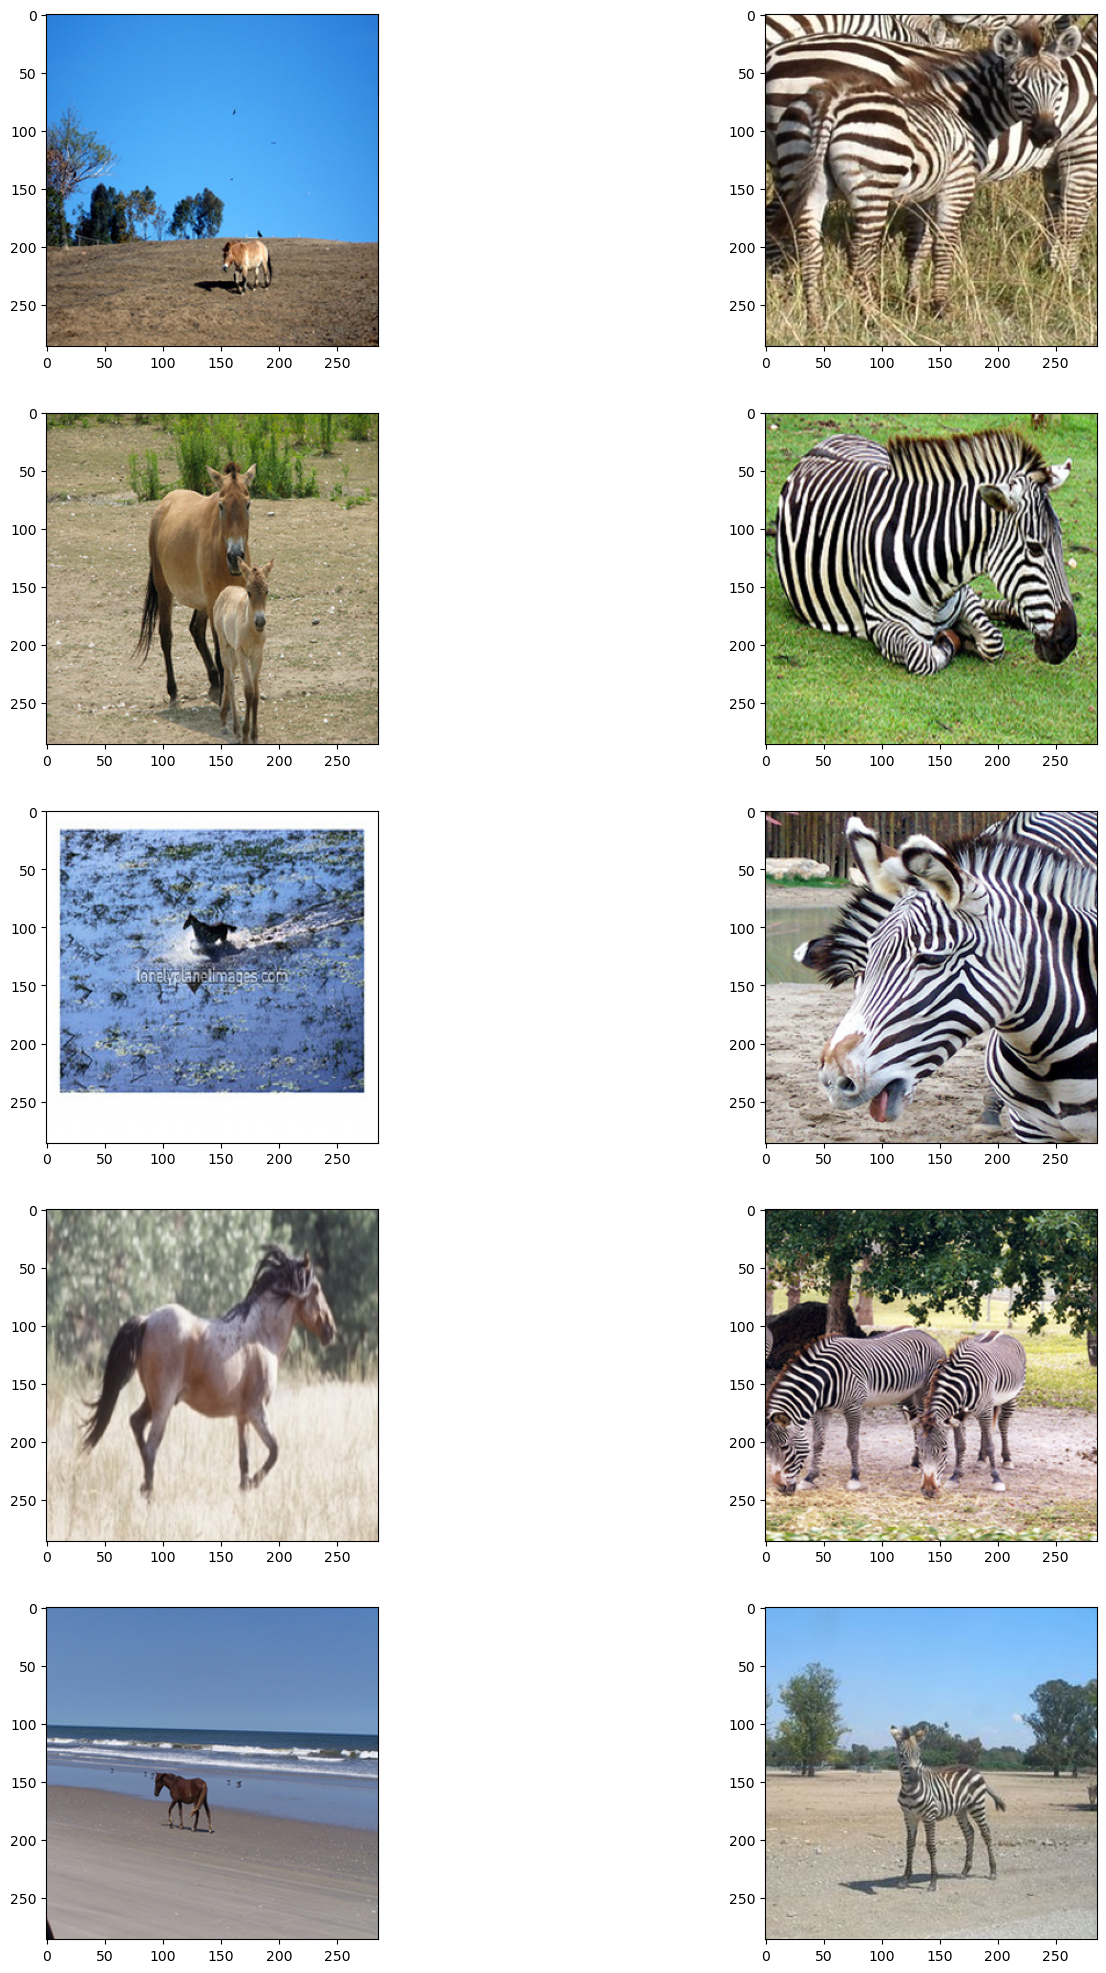

In [17]:
# %%capture --no-stdout
# , , --no-display and --output
import matplotlib.pyplot as plt
import numpy as np
IMGS_CNT = 5
plt.figure(figsize=(17,5*IMGS_CNT))
for i, idx in enumerate(np.random.choice(np.arange(len(dataset)), size=IMGS_CNT, replace=False)):
    data = dataset[idx]
    img1, img2 = [(1+data[x])/2 for x in ['src', 'dst']]
    plt.subplot(IMGS_CNT, 2, 2*i+1)
    plt.imshow(img1.permute(1,2,0).detach().cpu().numpy())
    plt.subplot(IMGS_CNT, 2, 2*i+2)
    plt.imshow(img2.permute(1,2,0).detach().cpu().numpy())

#Problems section

## Задача 1 (4/10). Построить ГАН.

>Здесь нужно обучить GAN до нормального качества, померить FID и запомнить для будущего сравнения.

> В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой.

> Ради интереса, ваш GAN тоже можно потестировать на маленьких датасетах

> **ГАН надо обучить генерить как зебр (`dst`), так и коней (`src`).**

In [18]:
import os
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

seed = 999
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
data_dir = './data/horse2zebra'
train_horses = os.path.join(data_dir, 'trainA')
train_zebras = os.path.join(data_dir, 'trainB')
test_horses = os.path.join(data_dir, 'testA')
test_zebras = os.path.join(data_dir, 'testB')

In [20]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from PIL import Image
import os

class HorseAndZebrasDataset(torch.utils.data.Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.A_images = sorted(os.listdir(rootA))
        self.B_images = sorted(os.listdir(rootB))
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return max(len(self.A_images), len(self.B_images))

    def __getitem__(self, idx):
        img_A = Image.open(os.path.join(self.rootA, self.A_images[idx % len(self.A_images)])).convert('RGB')
        img_B = Image.open(os.path.join(self.rootB, self.B_images[idx % len(self.B_images)])).convert('RGB')

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}


In [21]:
def get_dataloaders(data_dir, batch_size):
    transform = Compose([
        Resize((64, 64)),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    train_dataset = HorseAndZebrasDataset(
        rootA=os.path.join(data_dir, 'trainA'),
        rootB=os.path.join(data_dir, 'trainB'),
        transform=transform
    )
    
    test_dataset = HorseAndZebrasDataset(
        rootA=os.path.join(data_dir, 'testA'),
        rootB=os.path.join(data_dir, 'testB'),
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [22]:
torch.cuda.empty_cache()

In [23]:
class Generator(nn.Module):
    def __init__(self, img_channels, feature_maps):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: img_channels x 64 x 64
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(feature_maps, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: img_channels x 64 x 64
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [25]:
# Определяем размеры для архитектуры DCGAN
noise_dim = 100
img_channels = 3
feature_maps_gen = 256
feature_maps_disc = 256

# Создаем модели
G = Generator(img_channels, feature_maps_gen).cuda()  # Генератор DCGAN
D = Discriminator(img_channels, feature_maps_disc).cuda()  # Дискриминатор DCGAN

In [26]:
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os


def train_dcgan_with_dataloaders(data_dir, epochs=50, batch_size=16, lr=0.0002):
    """
    Обучение DCGAN с использованием лошадей как реальных изображений и генерации новых.
    
    Аргументы:
    - data_dir: Путь к папке с датасетом (структура: trainA, trainB, testA, testB).
    - epochs: Количество эпох обучения.
    - batch_size: Размер батча.
    - img_size: Размер изображений (будут изменены до img_size x img_size).
    - lr: Скорость обучения.
    
    Возвращает:
    - Путь к папке с результатами.
    """
    # Получаем загрузчики данных
    train_loader, _ = get_dataloaders(data_dir, batch_size=batch_size)

    # Оптимизаторы
    G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    # Функция потерь
    adversarial_loss = nn.BCELoss()

    # Папка для сохранения результатов
    results_dir = "dcgan_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Обучение
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            horse_imgs = batch['A'].cuda()  # Используем реальные изображения лошадей
            batch_size = horse_imgs.size(0)

            # === ОБНОВЛЕНИЕ ДИСКРИМИНАТОРА ===
            D_optimizer.zero_grad()

            # Реальные изображения
            real_preds = D(horse_imgs)
            real_labels = torch.ones_like(real_preds).cuda()  # Метки для реальных изображений
            real_loss = adversarial_loss(real_preds, real_labels)

            # Сгенерированные изображения
            noise = torch.randn(batch_size, 3, 64, 64).cuda()  # Генерируем шум с размером изображения
            fake_imgs = G(noise)
            fake_preds = D(fake_imgs.detach())
            fake_labels = torch.zeros_like(fake_preds).cuda()  # Метки для сгенерированных изображений
            fake_loss = adversarial_loss(fake_preds, fake_labels)

            # Итоговая потеря дискриминатора
            D_loss = (real_loss + fake_loss) / 2
            D_loss.backward()
            D_optimizer.step()

            # === ОБНОВЛЕНИЕ ГЕНЕРАТОРА ===
            G_optimizer.zero_grad()

            fake_preds = D(fake_imgs)
            gan_loss = adversarial_loss(fake_preds, torch.ones_like(fake_preds).cuda())  # Генератор должен обмануть дискриминатор

            # Потеря генератора
            G_loss = gan_loss
            G_loss.backward()
            G_optimizer.step()

            # Обновление прогресс-бара
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(G_loss=G_loss.item(), D_loss=D_loss.item())

        # Сохранение сгенерированных изображений
        save_image((fake_imgs[:16] + 1) / 2, f"{results_dir}/epoch_{epoch}_fake_images.png")

    return results_dir



In [27]:
data_dir = "data/horse2zebra"
train_dcgan_with_dataloaders(data_dir, epochs=50, batch_size=16, lr=0.0002)

Epoch [49/50]: 100%|██████████| 84/84 [00:08<00:00,  9.75it/s, D_loss=0.373, G_loss=4.39]  


'dcgan_results'

In [28]:
import os
import torch
from torchvision.utils import save_image

def generate_images(generator, output_dir, num_images=16, noise_dim=100, img_size=64, device=None):
    """
    Генерация изображений с помощью обученного генератора DCGAN.
    
    Аргументы:
    - generator: Обученный генератор DCGAN.
    - output_dir: Путь к папке для сохранения сгенерированных изображений.
    - num_images: Количество изображений для генерации.
    - noise_dim: Размерность шума, подаваемого на вход генератору.
    - img_size: Размер изображений (ширина и высота).
    - device: Устройство для выполнения (CPU или GPU).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Убедимся, что папка для сохранения изображений существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Переводим генератор в режим оценки
    generator.eval()

    # Создаем случайный шум
    noise = torch.randn(num_images, 3, 64, 64).to(device)

    with torch.no_grad():
        # Генерация изображений
        generated_images = generator(noise)

    # Нормализуем изображения для сохранения
    generated_images = (generated_images + 1) / 2  # Перевод значений из [-1, 1] в [0, 1]

    # Сохраняем сгенерированные изображения
    for i in range(num_images):
        save_image(generated_images[i], os.path.join(output_dir, f"generated_image_{i + 1}.png"))

    print(f"{num_images} сгенерированных изображений сохранены в папке: {output_dir}")


In [29]:
output_dir = "generated_images"
num_images = 32
noise_dim = 100

generate_images(G, output_dir, num_images=num_images, noise_dim=noise_dim)

32 сгенерированных изображений сохранены в папке: generated_images


In [30]:
from pytorch_fid import fid_score

def calculate_fid(real_dir, generated_dir, batch_size=16):
    """
    Вычисление FID метрики между реальными и сгенерированными изображениями.
    
    Аргументы:
    - real_dir: Путь к папке с реальными изображениями.
    - generated_dir: Путь к папке с сгенерированными изображениями.
    - batch_size: Размер батча для FID-вычислений.
    
    Возвращает:
    - FID метрику.
    """
    fid_value = fid_score.calculate_fid_given_paths(
        [real_dir, generated_dir],
        batch_size=batch_size,
        device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
        dims=2048
    )
    print(f"FID: {fid_value}")
    return fid_value

In [31]:
# Пути для вычисления FID
real_horses_dir = "data/horse2zebra/testA"  # Реальные лошади

# Сгенерированные данные
generated_dir = "generated_images"  

# FID
fid_horse = calculate_fid(real_horses_dir, generated_dir)

print(f"FID: {fid_horse}")

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


FID: 327.83284738777115
FID: 327.83284738777115


In [32]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_generated_images(image_dir, num_images=5):
    """
    Отображает несколько сгенерированных изображений из указанной директории.
    
    Аргументы:
    - image_dir: Путь к папке с изображениями.
    - num_images: Количество изображений для отображения.
    """
    # Получение списка файлов в директории
    image_files = sorted(os.listdir(image_dir))[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)

        # Отображение изображения
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")
    
    plt.tight_layout()
    plt.show()


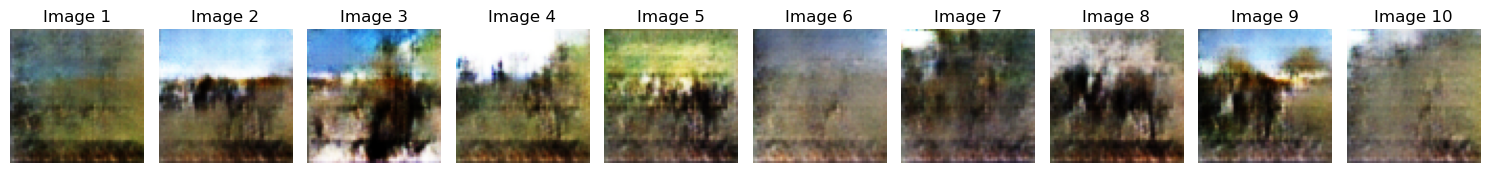

In [33]:
generated_dir = "generated_images"
display_generated_images(generated_dir, num_images=10)


In [34]:
torch.save(G.state_dict(), 'cached_models/G.pth')
torch.save(D.state_dict(), 'cached_models/D.pth')

## Задача 2 (6/10). Построить Cycle GAN.

> Используя ГАНы из Задачи 1, надо построить CycleGAN ([статья](https://arxiv.org/pdf/1703.10593)), обучить его до сравнимого с отдельными ГАНами качества, померить FID и запомнить для будущего сравнения.

In [40]:
# Параметры моделей
noise_dim = 100
img_channels = 3
feature_maps = 64

# Создаем модели
G_A2B = Generator(img_channels, feature_maps).cuda()  # Генератор: A -> B
G_B2A = Generator(img_channels, feature_maps).cuda()  # Генератор: B -> A
D_A = Discriminator(img_channels, feature_maps).cuda()           # Дискриминатор для домена A
D_B = Discriminator(img_channels, feature_maps).cuda()           # Дискриминатор для домена B

In [41]:
def train_cyclegan(data_dir, epochs=50, batch_size=16, lr=0.0002, lambda_cycle=10):
    """
    Обучение CycleGAN с использованием генератора и дискриминатора, совместимых с DCGAN.

    Аргументы:
    - data_dir: Путь к папке с датасетом (структура: trainA, trainB, testA, testB).
    - epochs: Количество эпох обучения.
    - batch_size: Размер батча.
    - img_size: Размер изображений (будут изменены до img_size x img_size).
    - lr: Скорость обучения.
    - lambda_cycle: Вес для потерь циклосогласованности.

    Возвращает:
    - Папка с результатами.
    """
    # Получаем загрузчики данных
    train_loader, _ = get_dataloaders(data_dir, batch_size=batch_size)

    # Оптимизаторы
    G_optimizer = optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
    D_A_optimizer = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
    D_B_optimizer = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

    # Функции потерь
    adversarial_loss = nn.MSELoss()  # Для дискриминаторов
    cycle_loss = nn.L1Loss()         # Для циклосогласованности

    # Папка для сохранения результатов
    results_dir = "cyclegan_results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Обучение
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            real_A = batch['A'].cuda()  # Изображения из домена A
            real_B = batch['B'].cuda()  # Изображения из домена B

            # === ОБНОВЛЕНИЕ ГЕНЕРАТОРОВ ===
            G_optimizer.zero_grad()

            # Преобразования
            fake_B = G_A2B(real_A)  # A -> B
            fake_A = G_B2A(real_B)  # B -> A

            # Восстановление исходных изображений
            cycle_A = G_B2A(fake_B)  # A -> B -> A
            cycle_B = G_A2B(fake_A)  # B -> A -> B

            # Потери циклосогласованности
            loss_cycle_A = cycle_loss(cycle_A, real_A)
            loss_cycle_B = cycle_loss(cycle_B, real_B)
            loss_cycle = lambda_cycle * (loss_cycle_A + loss_cycle_B)

            # Потери генераторов
            loss_G_A2B = adversarial_loss(D_B(fake_B), torch.ones_like(D_B(fake_B)))
            loss_G_B2A = adversarial_loss(D_A(fake_A), torch.ones_like(D_A(fake_A)))
            loss_G = loss_G_A2B + loss_G_B2A + loss_cycle

            loss_G.backward()
            G_optimizer.step()

            # === ОБНОВЛЕНИЕ ДИСКРИМИНАТОРА A ===
            D_A_optimizer.zero_grad()
            loss_D_A_real = adversarial_loss(D_A(real_A), torch.ones_like(D_A(real_A)))
            loss_D_A_fake = adversarial_loss(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
            loss_D_A = (loss_D_A_real + loss_D_A_fake) / 2

            loss_D_A.backward()
            D_A_optimizer.step()

            # === ОБНОВЛЕНИЕ ДИСКРИМИНАТОРА B ===
            D_B_optimizer.zero_grad()
            loss_D_B_real = adversarial_loss(D_B(real_B), torch.ones_like(D_B(real_B)))
            loss_D_B_fake = adversarial_loss(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
            loss_D_B = (loss_D_B_real + loss_D_B_fake) / 2

            loss_D_B.backward()
            D_B_optimizer.step()

            # Обновление прогресс-бара
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(G_loss=loss_G.item(), D_A_loss=loss_D_A.item(), D_B_loss=loss_D_B.item())

        # Сохранение результатов
        save_image(fake_B[:16], f"{results_dir}/epoch_{epoch}_fake_B.png", normalize=True)
        save_image(fake_A[:16], f"{results_dir}/epoch_{epoch}_fake_A.png", normalize=True)

    return results_dir

In [42]:
# Параметры для обучения
data_dir = "data\horse2zebra"  # Укажите путь к вашему датасету (структура: trainA, trainB, testA, testB)
epochs = 50                      # Количество эпох
batch_size = 16                   # Размер батча
lr = 0.0002                       # Скорость обучения
lambda_cycle = 10                 # Вес для потерь циклосогласованности

# Запуск обучения
results_dir = train_cyclegan(
    data_dir=data_dir,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    lambda_cycle=lambda_cycle
)

print(f"Результаты обучения сохранены в папке: {results_dir}")

Epoch [49/50]: 100%|██████████| 84/84 [00:05<00:00, 16.06it/s, D_A_loss=0.118, D_B_loss=0.0297, G_loss=5.32]    

Результаты обучения сохранены в папке: cyclegan_results


In [56]:
def save_generated_images(generator_A2B, generator_B2A, data_loader, output_dir, num_images=100, device=None):
    """
    Сохраняет сгенерированные изображения из доменов A -> B и B -> A.
    
    Аргументы:
    - generator_A2B: Генератор A -> B.
    - generator_B2A: Генератор B -> A.
    - data_loader: Загрузчик данных.
    - output_dir: Путь для сохранения изображений.
    - num_images: Количество изображений для сохранения.
    - device: Устройство (CPU или GPU).
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    generator_A2B.eval()
    generator_B2A.eval()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    fake_A_dir = os.path.join(output_dir, "fake_A")
    fake_B_dir = os.path.join(output_dir, "fake_B")
    
    if not os.path.exists(fake_A_dir):
        os.makedirs(fake_A_dir)
        
    if not os.path.exists(fake_B_dir):
        os.makedirs(fake_B_dir)

    saved_images = 0
    with torch.no_grad():
        for batch in data_loader:
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            fake_B = generator_A2B(real_A)  # A -> B
            fake_A = generator_B2A(real_B)  # B -> A

            fake_B = (fake_B + 1) / 2  # Нормализация в диапазон [0, 1]
            fake_A = (fake_A + 1) / 2

            for i in range(fake_B.size(0)):
                if saved_images >= num_images:
                    return
                save_image(fake_B[i], os.path.join(fake_B_dir, f"{saved_images + 1}.png"))
                save_image(fake_A[i], os.path.join(fake_A_dir, f"{saved_images + 1}.png"))
                saved_images += 1


In [57]:
generated_images_dir = "generated_images_by_cycle_gan"
train_loader, _ = get_dataloaders(data_dir, batch_size=batch_size)
# Сохранение сгенерированных изображений
save_generated_images(
    generator_A2B=G_A2B,
    generator_B2A=G_B2A,
    data_loader=train_loader,
    output_dir=generated_images_dir,
    num_images=100,
    device='cuda'
)

In [58]:
fid_A2B = calculate_fid(real_dir="data/horse2zebra/testA", generated_dir=os.path.join(generated_images_dir, "fake_A"))
fid_B2A = calculate_fid(real_dir="data/horse2zebra/testB", generated_dir=os.path.join(generated_images_dir, "fake_B"))

print(f"FID A -> B: {fid_A2B}")
print(f"FID B -> A: {fid_B2A}")

100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


FID: 288.06775262760067


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


FID: 359.67693363401645
FID A -> B: 288.06775262760067
FID B -> A: 359.67693363401645


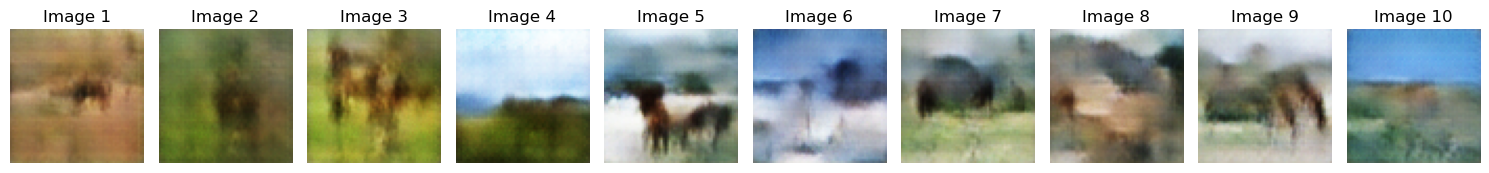

In [60]:
display_generated_images(os.path.join(generated_images_dir, "fake_A"), num_images=10)

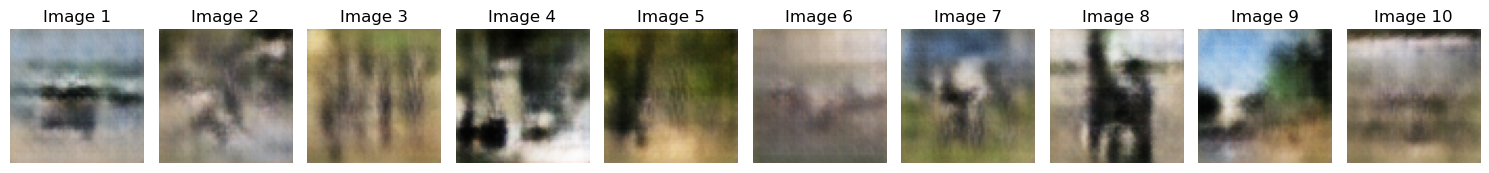

In [61]:
display_generated_images(os.path.join(generated_images_dir, "fake_B"), num_images=10)

## Задача 3 (1/10). Анализ.

> Проанализируйте результаты полученные моделями.

> Покажите хорошие и плохие примеры моделей. Чем можно объяснить подобное поведение моделей? Подчеркните проблемы предложенной модели, которые вы заметили, и возможные решения.

> Покажите самый смешной результат генерации, который у вас получался.

В целом, хороших вариантов нету, результат плохой.
Возможно качество бы улучшилось, если бы было больше эпох.


Вот здесь что-то похожее на лошадей. Но больше похоже на картину из Minecraft'a...

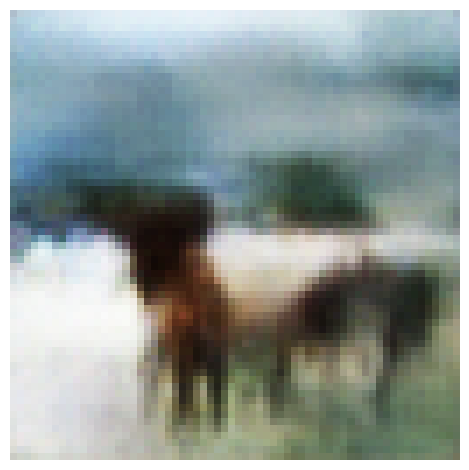

In [40]:
img = Image.open('generated_images_by_cycle_gan/fake_A/12.png')

plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()
